In [2]:
"""
Load:
  x_a_init.txt
Save:
  x_b.txt
  x_a.txt
"""
import numpy as np
from scipy.integrate import ode
import lorenz96
import matplotlib.pyplot as plt
from settings import *
import matplotlib.pyplot as plt

In [3]:
def get_TLM(x): #x=[x1,x2,x3,...,xn]
    y = np.zeros((40,40))
    z = np.zeros((40,40))
    for n in range(40):
        z[n][n] = -1
        z[n][np.mod(n+1+1,40)-1] = x[np.mod(n-1+1,40)-1]
        z[n][np.mod(n-1+1,40)-1] = x[np.mod(n+1+1,40)-1]
        #print(np.mod(n-2+1,40)-1)
        z[n][np.mod(n-2+1,40)-1] = -1*x[np.mod(n+1+1,40)-1]
    return z

In [4]:
#x = np.arange(40)
#print(x)
#w = get_TLM(x) 
#print(w)

#x = np.arange(40)
#print(F(x))

In [5]:
#print(np.reshape(x_a_save[0],[40,1]))
#z = get_TLM(np.reshape(x_a_save[0],[40,1]))
#print(z)

In [70]:
"""
Load:
  x_a_init.txt
Save:
  x_b.txt
  x_a.txt
"""
import numpy as np
from scipy.integrate import ode
import lorenz96
import matplotlib.pyplot as plt
from settings import *
nT = 800

#set random seed
np.random.seed(201910)

#load true value
x_t_save = np.genfromtxt('x_t.txt')



# load initial condition
x_a_init = np.genfromtxt('x_a_init.txt')
analysis_error = 25.e-2

np.random.seed(20191031)
# create observations

observation_error = 25.e-2
y_o_save = np.zeros([nT+1, N])
y_o_save = x_t_save + observation_error * np.random.randn(nT+1, N)


# initial x_b: no values at the initial time (assign NaN)
#x_b_save = np.full((1,N), np.nan, dtype='f8')
x_b_save = np.array([x_a_init])#test

##print(x_b_save)
# initial x_a: from x_a_ens_init

x_a_save = np.array([x_a_init])
#x_a_save = []
##print(x_a_save)


tt = 0#was 1

B = 0.0844 * np.identity(40)#backound error covariance 
#B = 0.25 * np.identity(40)#backound error covariance 

#B = np.genfromtxt('B_1224_raw.txt')
#B = B*0.6
R = 0.25 * np.identity(40) #observation error covariance

for i in range(40):
    for j in range(40):
        i = j
        if j+1 != 40:
            B[i][j+1] = 0.0064
        else:
            B[i][j+1-40] = 0.0064
            
        if j+1 != 40 and j+2 != 40:
            B[i][j+2] = -0.013
        else:
            B[i][j+2-40] = -0.013
            
        if j-1 != -1 :
            B[i][j-1] = +0.0064
        else:
            B[i][j-2+40] = +0.0064
            
        if j-2 != -1 and j-1 != -1:
            B[i][j-2] = -0.013
        else:
            B[i][j-2+40] = -0.013

B_temp_2 = B.copy()
B_a = np.reshape(B_f_mean,[40,40,1])
B_f = np.reshape(B_f_mean,[40,40,1])
#B_f = np.concatenate((B_f, np.reshape(B_f,[40,40,1])), axis = 2)
#B_f = np.concatenate((B_f, np.reshape(B_f,[40,40,2])), axis = 2)
#print(B_f.shape)
#print(np.dsplit(B_f,4)[1].shape)

while tt <= nT:
    ttf = tt + 1
    Ta = tt  * dT  # forecast start time(DA time)
    Tf = ttf * dT  # forecast end time
    #print('Cycle =', tt, ', Ta =', round(Ta, 10), ', Tf =', round(Tf, 10))
    #--------------
    # analysis step
    #--------------
    # background

    B = np.reshape(np.dsplit(B_f,ttf)[tt],[40,40])#.shape    
    
    x_b = x_b_save[tt].transpose()

    # observation
    y_o = y_o_save[tt].transpose()
    # innovation

    H = np.identity(40)
    y_b = np.dot(H, x_b)
    d = y_o - y_b

    # analysis scheme 
    K = np.dot(B, np.dot(H, np.linalg.inv(np.dot(H, np.dot(B,H))+R)))

    x_a = x_b + np.dot(K,d)

    if tt == 0: 
        x_a_save = np.reshape(x_a.transpose(),[1,40])
    else:
        x_a_save = np.vstack([x_a_save, x_a.transpose()])
        

    
    B_temp = B-np.dot(K,np.dot(H,B))
    B_a = np.concatenate((B_a, np.reshape(B_temp,[40,40,1])), axis = 2)
    #B_a = np.stack([B_a,B_temp], axis = 2)
    

    #--------------
    # forecast step
    #--------------

    solver = ode(lorenz96.f).set_integrator('dopri5')
    solver.set_initial_value(x_a_save[tt], Ta).set_f_params(F)
    solver.integrate(Tf)

    x_b_save = np.vstack([x_b_save, [solver.y]])
    TLM = get_TLM(np.reshape(x_a_save[0],[40,1]))

    
    B_f_temp = B_temp + (np.dot(get_TLM(np.reshape(x_a_save[tt],[40,1])),B_temp)+np.dot(get_TLM(np.reshape(x_a_save[tt],[40,1])),B_temp).transpose())*0.004
    B_f_temp = B_f_temp*1.25
    #print("trace = ", np.trace(B_f_temp))
    B_f = np.concatenate((B_f, np.reshape(B_f_temp,[40,40,1])), axis = 2)
    
    
    tt += 1

# save background and analysis data
x_b_save = x_b_save[0:801][:]
np.savetxt('x_b.txt', x_b_save)
np.savetxt('x_a.txt', x_a_save)

#Do simple statistic
analysis_error = x_a_save-x_t_save
bias_t = []
rmse_t = []
for i in range(nT):
    
    bias_i = analysis_error[i][:].mean()
    rmse_i = np.std(analysis_error[i][:])
    bias_t = np.append(bias_t, bias_i)
    rmse_t = np.append(rmse_t, rmse_i)
rmse = rmse_t[30:800].mean()
bias = bias_t[30:800].mean()
print(rmse)

0.09814419081785357


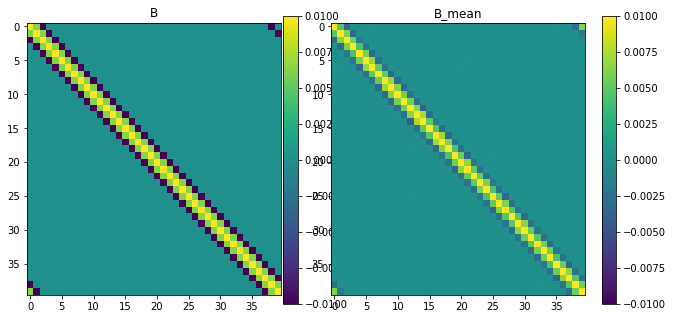

In [66]:
#print(B_f.shape)
#print(np.mean(B_f, axis = 2).shape)
#B_f_mean = np.mean(B_f, axis = 2)


fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(B_temp_2,vmin=-0.01,vmax=0.01)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('B_mean')
plt.imshow(B_f_mean,vmin=-0.01,vmax=0.01)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [26]:
print(B.size)
print(B.shape)
B_2 = np.concatenate([np.reshape(B,[40,40,1]),np.reshape(B,[40,40,1])], axis = 2)
print(B_2.shape)
B_3 = np.concatenate((B_2,np.reshape(B,[40,40,1])), axis = 2)
#B = np.vstack([B, B])
print(B_3.shape)
#print(B)

1600
(40, 40)
(40, 40, 2)
(40, 40, 3)


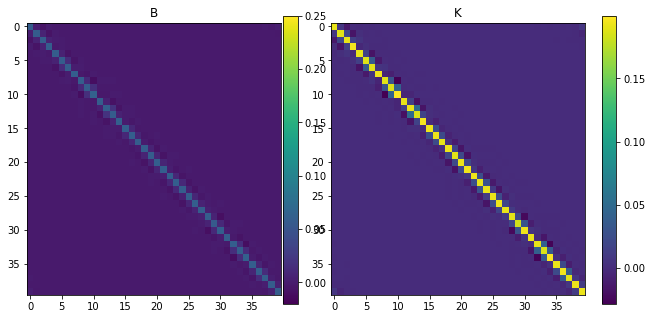

In [45]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(B,vmin=-0.02,vmax=0.25)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('K')
plt.imshow(K)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [ ]:
#for i in range(10):
#    plt.plot(x_a_save[:][i])
#    #print(x_a_save[:][200])
#    plt.show()

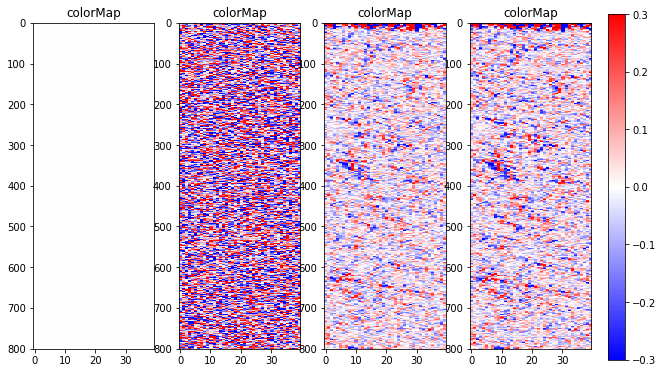

In [46]:
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(141)
ax.set_title('colorMap')
plt.imshow(x_t_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax.set_aspect('auto')

ax2 = fig.add_subplot(142)
ax2.set_title('colorMap')
plt.imshow(y_o_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax2.set_aspect('auto')


ax3 = fig.add_subplot(143)
ax3.set_title('colorMap')
plt.imshow(x_a_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax3.set_aspect('auto')


ax4 = fig.add_subplot(144)
ax4.set_title('colorMap')
plt.imshow(x_b_save[0:801][:]-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax4.set_aspect('auto')


cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()